In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define Functions

In [2]:
from SCC_functions import *

In [3]:
## calculate abatement given a carbon price

# default settings
P_50 = 100  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5
consumption_growth = 0.02
W_2019 = 80
consumption_discount=0.035
s = 0.05
r = 0.04

def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [4]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [5]:
start_year = 2020
end_year = 3000

years = create_years_array(start_year, end_year)
num_of_years = len(years)

In [6]:
# start_year = 1750
# last_historical_year = 2019
# end_year = 3000

# years = np.arange(start_year, end_year+1)

In [7]:
# historical_years = np.arange(start_year, last_historical_year+1)
# CO2_column = 1.2 * np.ones(len(historical_years))
# T_gas = {'year': historical_years, 'CO2_best': CO2_column}

In [8]:
T_0 = 1.2

In [9]:
delta_T = 3
alpha = 0.02
T = create_geometric_T(years, T_0=T_0, alpha=alpha, delta_T=delta_T)

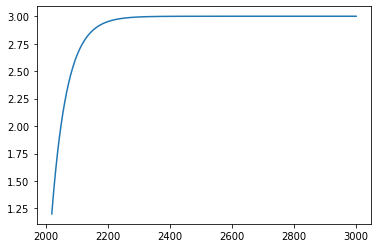

In [10]:
plt.plot(years, T)

## Total Consumption

In [11]:
W = create_total_consumption(years, W_fixed_year=2020, W_fixed=80)

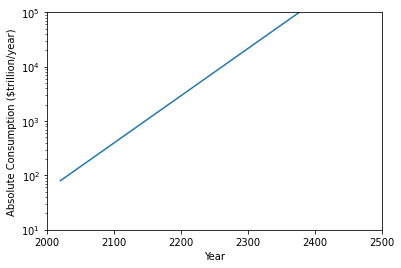

In [12]:
plt.plot(years, W)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
# plt.xlim(2000, 2100)
# plt.ylim(0, 400)
plt.xlim(2000, 2500)
plt.ylim(10, 100000)
plt.yscale("log")

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [13]:
T_TCRE_1 = 0.00054  # need to check this for FAIR!
k_s = 0.12
size_of_perturbation = 1

In [14]:
gamma = 2
D0 = 0.00267

In [15]:
## years to calculate SCC
first_perturbed_year = start_year
last_perturbed_year = 2500
year_of_perturbation = create_years_array(start_year, last_perturbed_year)

# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    

#     T_p = np.zeros(num_of_years)
#     for i in range(num_of_years):
#         if year_of_perturbation[j] <= years[i]:
#             T_p[i] = T_TCRE*(1-np.exp(-k_s*(years[i]-year_of_perturbation[j])))
#     T_forecast_perturbed = T+T_p
#     T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    T_perturbed = create_geometric_T_perturbed(years, T=T, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)

    ## define discount function
#     num_of_years = len(years)
#     discount_function = np.zeros(num_of_years)

#     for i in range(num_of_years):
#         if years[i] >= year_of_perturbation[j]:
#             discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
#     if j == 0:
#         print(T[first_perturbed_year-start_year+1])
#         print(T_perturbed[first_perturbed_year-start_year+1])
#         print(W[first_perturbed_year-start_year+1])
#         print(discount_function[first_perturbed_year-start_year+1])
    ## calculate SCC
#     cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
#     SCC = cost/(10**9)
    
    discount_function = create_discount_function(years, year_of_perturbation[j])
    
    time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T, 'T perturbed': T_perturbed}

    time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

    SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)
    
    if j  == 0:
        print(SCC)

    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

31.826890094939316


In [16]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

Text(0, 0.5, 'SCC ($)')

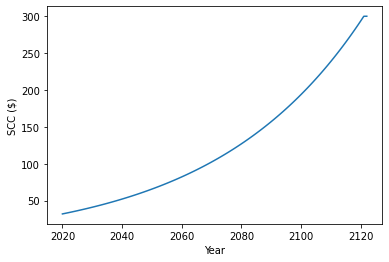

In [17]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [18]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [19]:
SCC_forecasted = []

for i in range(num_of_years):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [20]:
# SCC_forecasted

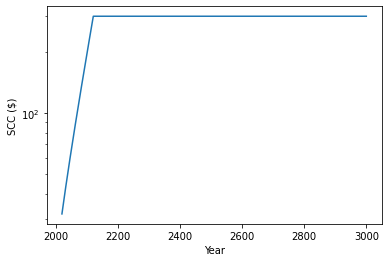

In [21]:
plt.plot(years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [22]:
P0 = SCC_forecasted[0]

In [23]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_42846/810535877.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

Text(0, 0.5, 'Abatement')

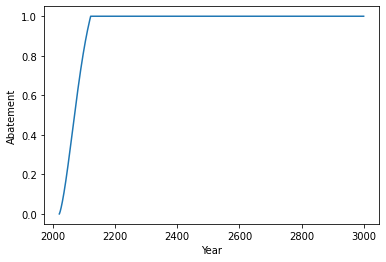

In [24]:
plt.plot(years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [25]:
# ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [26]:
# ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [27]:
# CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [28]:
CO2_baseline = 40.339401131162724

In [29]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

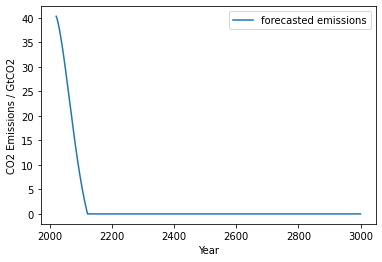

In [30]:
# plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

In [31]:
# for i in range(len(forecasted_emissions)-1):
#     step = forecasted_emissions[i] - forecasted_emissions[i+1]
#     if step > 0.4:
#         print(i)

## 5. Cumulative Emissions to Temperature Change

In [32]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [33]:
temperature_change = T_TCRE_1*cumulative_emissions_array

In [34]:
max(temperature_change)

1.0963074130275574

In [35]:
T_forecast_iteration0 = T_0 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

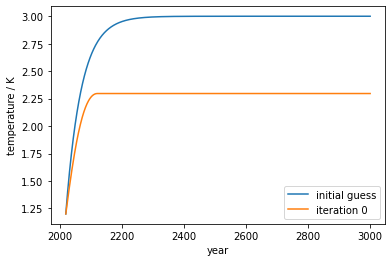

In [36]:
plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [37]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [38]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

27.14538098571273


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_42846/810535877.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


28.317366190159557


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_42846/810535877.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


27.932296750541123


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_42846/810535877.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


28.05897564001003


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_42846/810535877.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


28.017136585999644
4


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_42846/810535877.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


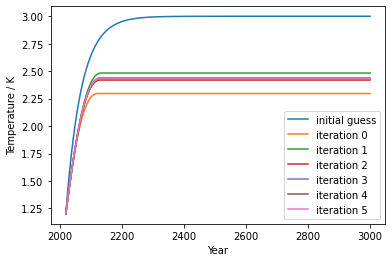

In [39]:
num_of_iterations = 99

first_perturbed_year = start_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
#     T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    

#     T_p = np.zeros(num_of_years)
#     for i in range(num_of_years):
#         if year_of_perturbation[j] <= years[i]:
#             T_p[i] = T_TCRE*(1-np.exp(-k_s*(years[i]-year_of_perturbation[j])))
#     T_forecast_perturbed = T+T_p
#     T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
        T_perturbed = create_geometric_T_perturbed(years, T=T_forecast_iteration, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)

    ## define discount function
#     num_of_years = len(years)
#     discount_function = np.zeros(num_of_years)

#     for i in range(num_of_years):
#         if years[i] >= year_of_perturbation[j]:
#             discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
#     if j == 0:
#         print(T[first_perturbed_year-start_year+1])
#         print(T_perturbed[first_perturbed_year-start_year+1])
#         print(W[first_perturbed_year-start_year+1])
#         print(discount_function[first_perturbed_year-start_year+1])
    ## calculate SCC
#     cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
#     SCC = cost/(10**9)
    
        discount_function = create_discount_function(years, year_of_perturbation[j])

        time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T_forecast_iteration, 'T perturbed': T_perturbed}

        time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

        SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)

        if j  == 0:
            print(SCC)

        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(num_of_years):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE_1*cumulative_emissions_array
    
    T_forecast_iteration = T_0 + temperature_change
    
    plt.plot(years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [40]:
## peak Temperature
max(T_forecast_iteration)

2.4351680299517406

under default settings: 2.435168016568933

- max ~2GtCO2 in year (look in IAMs)
- directions MACC non...
- comment on efficiency
- equation on flowchart
- balance between forcing log and errors
- gradient MACC
- table for Sobol
- peak warming and year of peak warming; scatter with growth rate